<a href="https://colab.research.google.com/github/suryogumilar/Tensorflow_timeseries/blob/main/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Layer Neural Network with Time Series Data

references:
 - https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go

## functions

we'll define some utility functions that we'll repeatedly use

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def plot_series_plotly(time, series, figure_title='', start=0, end=None):
    """
    Visualizes time series data but using plotly for interactive graph

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    fig = go.Figure()
    # Setup dimensions of the graph figure
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series_num[start:end], mode='lines'))  

    else:
      # Plot the time series data
      fig.add_trace(go.Scatter(x=time[start:end],
                                 y=series[start:end], mode='lines'))

    fig.update_layout(title=figure_title, xaxis_title="Time", yaxis_title="Value",
                      autosize=False,
                      width=600,
                      height=600,
                      margin=dict(
                        l=50,
                        r=50,
                        b=100,
                        t=100,
                        pad=4
                        ), paper_bgcolor="LightSteelBlue"
                        #, showlegend=True
                      )
    fig.show()



def getStockData(history_span:int, the_ticker:str):
  """
  Getting stock data from Yahoo Finance API

  Args:
    history_span (int) how much backdate data to be collected
    the_ticker (string) ticker name on yahoo finance API
  Returns:
    Pandas dataframe (pd.DataFrame) containing stock data    
  """
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df

In [ ]:
stock_name = str(input("Stock tick:"))
hist_data = int(input("historical data (year):"))

In [4]:
df = getStockData(hist_data, stock_name)

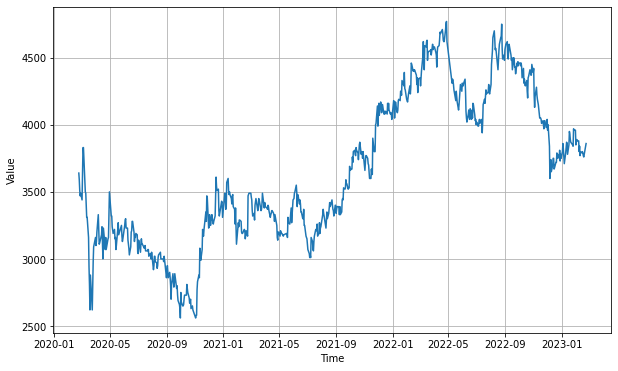

In [5]:
plot_series(df['Date'], df['Close'])

#### plotly version of the graph

We use plotly version displaying the data for interactive gtraph

In [6]:
plot_series_plotly(df['Date'], df['Close'], 'price')

In [7]:
fig = go.Figure(data= [go.Candlestick(x=df['Date'],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close']
                             )])
fig.show()

## Split the Dataset

We split the dataset as training and test


In [8]:
split_ratio = 0.8
rows_of_dataframe = df.shape[0]

training_ds_rows = round(rows_of_dataframe * split_ratio)
test_ds_rows = round(rows_of_dataframe * (1- split_ratio))

print(training_ds_rows)
print(test_ds_rows)

df_training = df[:training_ds_rows]
df_test = df[training_ds_rows:]

print(df.shape)
print(df_training.shape)
print(df_test.shape)


588
147
(735, 7)
(588, 7)
(147, 7)


Please do note in mind that when splitting the data into training and test set always take care on the distribution of data. Does it represent data on each month equally? Does the data have seasonal feature in it? Does it actually creates bias instead?

In [9]:
plot_series_plotly(df_training['Date'], df_training['Close'], 'training dataset')

In [10]:
plot_series_plotly(df_test['Date'], df_test['Close'], 'test dataset')

## Prepare features and labels

prepare window data for time series forecasting

#### Parameters

we define parameters here

`window_size = 20` means we are going to predict future data using 20 previous data. 

One thing to note here is the `window_size + 1` when we call `dataset.window()`. There is a `+ 1` to indicate that we're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [11]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

generate windowed train dataset

In [13]:
# Generate the dataset windows
dataset = windowed_dataset(df_training[['Open', 'Close']], window_size, 
                           batch_size, shuffle_buffer_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


We can inspect the output to see if the function is behaving as expected. The code below will use the `take()` method of the `tf.data.Dataset` API to grab a single batch. It will then print several properties of this batch such as the data type and shape of the elements. As expected, it should have a 2-element tuple (i.e. (`feature`, `label`)) and the shapes of these should align with the batch and window sizes you declared earlier which are 32 and 20 by default, respectively.

In [14]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20, 2)
shape of second element: (32, 2)


here, since we used 'Open' and 'Close' data we get 2 as the last order of each element

`number of elements in the tuple: 2` means each windowed dataset has feature and label data as a tuple

`shape of first element: (32, 20, 2)` means this is the first batched feature data, it has 32 rows of data since we set `batch_size=32` and 20 columns of windowed data of each features (here they are `Open` and `Close`) as `window_size=20` and last dimension 2 means the feature were `Open` and `Close` data

Now we're going to use `Close` data (Univariate) instead of using 2 features of `Open`and `Close` (Multivariate)

In [15]:
# Generate the dataset windows
dataset = windowed_dataset(df_training['Close'], window_size, 
                           batch_size, shuffle_buffer_size)

# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model

We will build the single layer neural network

In [44]:
class TSSequentialModel(tf.keras.Model):
  def __init__(self, **kwargs):
    ws = kwargs['window_size']
    # remove Keyword argument not understood by keras model
    kwargs.pop('window_size')
    super(TSSequentialModel, self).__init__(**kwargs)
    self.dense_1 = tf.keras.layers.Dense(1, input_shape=[window_size],
                                         activation="relu")
    
    ## if we only add dense layer only, the output shape of the model would be multiple
    ## thus we need to add sequential model so that the output shape would be in order of 1
    self.sequential_1 = tf.keras.models.Sequential(self.dense_1)
    # Print the initial layer weights
    print("Layer weights: \n {} \n".format( self.dense_1.get_weights()))

  def call(self, x):
    #x = self.dense_1(x)
    x = self.sequential_1(x)
    return x
    

here we call function `build()` explicitely since we do not use `Sequential` model with `InputLayer` at the beginning OR if we apply input data `model(input_data)`. In both cases `model.build() is called implicitly

 - https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary

In [45]:
model = TSSequentialModel(window_size=window_size)

input_shape = (1, window_size)
model.build(input_shape)

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.48253736],
       [ 0.38958025],
       [ 0.0531922 ],
       [ 0.428025  ],
       [ 0.22118157],
       [ 0.26052105],
       [-0.3738111 ],
       [-0.06965709],
       [-0.02426398],
       [ 0.06007856],
       [ 0.2875287 ],
       [-0.5092785 ],
       [ 0.47357994],
       [-0.5282797 ],
       [ 0.15083659],
       [ 0.25771403],
       [-0.2010319 ],
       [-0.04029438],
       [ 0.22202444],
       [ 0.20914549]], dtype=float32), array([0.], dtype=float32)] 

Model: "ts_sequential_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
 sequential (Sequential)     (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
______

We set [*mean squared error (mse)*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError) as the loss function and use [*stochastic gradient descent (SGD)*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) to optimize the weights during training.

In [46]:
# Set the training parameters
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9))



## Train the Model

using epoch=100

In [47]:
# Train the model
history = model.fit(dataset,epochs=100, verbose=2)

Epoch 1/100
18/18 - 0s - loss: 8930675822428160.0000 - 459ms/epoch - 25ms/step
Epoch 2/100
18/18 - 0s - loss: 12799138.0000 - 107ms/epoch - 6ms/step
Epoch 3/100
18/18 - 0s - loss: 12799137.0000 - 114ms/epoch - 6ms/step
Epoch 4/100
18/18 - 0s - loss: 12799139.0000 - 110ms/epoch - 6ms/step
Epoch 5/100
18/18 - 0s - loss: 12799139.0000 - 112ms/epoch - 6ms/step
Epoch 6/100
18/18 - 0s - loss: 12799138.0000 - 98ms/epoch - 5ms/step
Epoch 7/100
18/18 - 0s - loss: 12799137.0000 - 104ms/epoch - 6ms/step
Epoch 8/100
18/18 - 0s - loss: 12799138.0000 - 106ms/epoch - 6ms/step
Epoch 9/100
18/18 - 0s - loss: 12799138.0000 - 123ms/epoch - 7ms/step
Epoch 10/100
18/18 - 0s - loss: 12799139.0000 - 104ms/epoch - 6ms/step
Epoch 11/100
18/18 - 0s - loss: 12799136.0000 - 174ms/epoch - 10ms/step
Epoch 12/100
18/18 - 0s - loss: 12799138.0000 - 203ms/epoch - 11ms/step
Epoch 13/100
18/18 - 0s - loss: 12799137.0000 - 196ms/epoch - 11ms/step
Epoch 14/100
18/18 - 0s - loss: 12799139.0000 - 184ms/epoch - 10ms/step
Epo

## Plot the model Loss

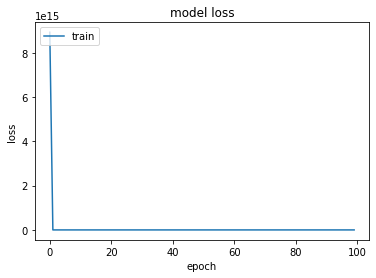

In [48]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
plot_series_plotly(np.arange(1, 100), history.history['loss'], 'loss value')

We got loss: 12799138.0000 which is realy bad in term of performance for the model (we want the loss value to be as small as possible)

But of course this is expected since we only use 1 single layer of network

### Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the [`np.newaxis`](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) constant or using the [`np.expand_dims()`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) method.

In [50]:
series = df['Close']
series_values = df['Close'].values

print(type(series))
print(type(series_values))

# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series_values[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series_values[0:20][np.newaxis])}')

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 49ms/step
model prediction: [[0.]]


The slice index below is `split_time - window_size:` because the forecast list is smaller than the series by 20 points (i.e. the window size). Since the window size is 20, the first data point in the `forecast` list corresponds to the prediction for time at index `20`. You cannot make predictions at index `0` to `19` because those are smaller than the window size. Thus, when you slice with `split_time - window_size:`, you will be getting the points at the time indices that aligns with those in the validation set.

*Note: You might notice that this cell takes a while to run. In the next two labs, you will see other approaches to generating predictions to make the code run faster. You might already have some ideas and feel free to try them out after completing this lab.*

In [51]:
print((df_training.shape))
print((df_test.shape))
len(df_test)

(588, 7)
(147, 7)


147

In [52]:
# Initialize a list
forecast = []
series = df['Close']
# Use the model to predict data points per window size
# we predict all of the data set, training and test
for time in range(series.shape[0] - window_size):
  forecast.append(model.predict(
      np.expand_dims(series[time:time + window_size], axis=0), verbose=0))

forecast_split = forecast[ training_ds_rows - window_size:]
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast_split)}')
print(f'shape of the validation set: {df_test.shape}')

length of the forecast list: 147
shape of the validation set: (147, 7)


To visualize the results, you will need to convert the predictions to a form that the plot_series() utility function accepts. That involves converting the list to a numpy array and dropping the single dimensional axes

shape after converting to numpy array: (147, 1, 1)
shape after squeezing: (147,)


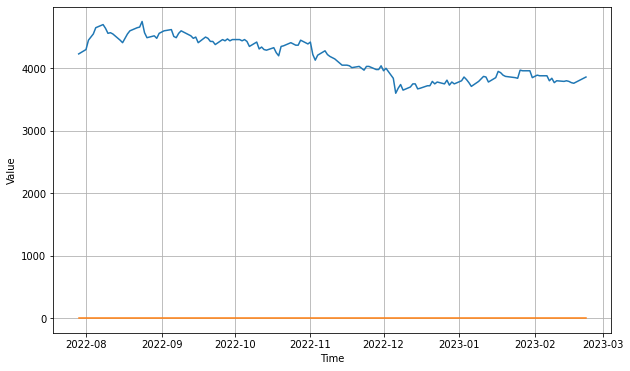

In [53]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast_split).shape}')
print(f'shape after squeezing: {np.array(forecast_split).squeeze().shape}')
# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast_split).squeeze()

# Overlay the results with the validation set
plot_series(df_test['Date'], (df_test['Close'], results))

In [54]:
plot_series_plotly(df_test['Date'], (df_test['Close'], results),
                   figure_title='dataset')

Bad, yes..but let us try another approach using normalization next time